# 1. Camera Calibration

This script intends to calibrate a camera using an object.\
For this implementation we will use the openCV method for calibration(https://docs.opencv.org/4.x/dc/dbb/tutorial_py_calibration.html)

**Import the libraries**

In [2]:
from platform import python_version

print(python_version())

3.9.7


In [3]:
from matplotlib import pyplot as plt
import numpy as np
import scipy as sp
import cv2

#for LM method
from scipy.optimize import curve_fit
#matplotlib widget

## Zhang's Method
Comparing to the DLT method, the Zhang method only calculate the intrinsic parameters. We instead only need to find 5 parameters.

## 2. Calibration

### 2.1 Finding the corner of the checkerboard
+ With 9 images, each one with 48 image points
+ The checkerboard has 25mm between corners

In [4]:
# number of images
n_imgs = 9
# pattern size
patternsize= (6,8)
#distance between squares(in mm)
dist = 25

# specified number of iterations are completed.
criteria = (cv2.TERM_CRITERIA_EPS +
            cv2.TERM_CRITERIA_MAX_ITER, 30, 0.001)

# Vector for 3D points
threedpoints = []
 
# Vector for 2D points
twodpoints = []

#3D points real world coordinates( static -> chessboard)
# create a matrix of zeros for 48 points , each with 3 coordinates
world_coo = np.zeros((1, patternsize[0]* patternsize[1],3), np.float32)
world_coo[:, :, :2] = np.mgrid[0:patternsize[0], 0:patternsize[1]].T.reshape(-1, 2)
# Transform coordinates in mm
world_coo = world_coo*dist

#prev_img_shape = None

for i in range(n_imgs):
    
    name = ("images/Chessboard_real_"+ str(i+1)+".jpeg")
    #Import the image
    img = cv2.imread(name)
    # convert it to gray scale
    gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)
    
    retval, corners= cv2.findChessboardCorners(gray,patternsize,cv2.CALIB_CB_ADAPTIVE_THRESH + cv2.CALIB_CB_FAST_CHECK +cv2.CALIB_CB_NORMALIZE_IMAGE)
    
    if(retval == True):
        threedpoints.append(world_coo)

        # Refining pixel coordinates or given 2d points.
        corners2 = cv2.cornerSubPix(gray, corners, (11, 11), (-1, -1), criteria).reshape(48,2)

        twodpoints.append(corners2)
        # Draw and display the corners
        #image = cv2.drawChessboardCorners(img,patternsize,corners2,retval)
        #plt.imshow(image)
        #plt.show()

# image coordinates and world coordinates for the diferent images( the world coordinates are always the same)
imagecoo = np.asarray(twodpoints)
worldcoo = np.asarray(threedpoints) 
print(imagecoo.shape)
print(worldcoo.shape)

(9, 48, 2)
(9, 1, 48, 3)


## Find the homographies

In [5]:
# empty list to store the homographies
H = np.zeros((n_imgs,3,3))
# world coordinates
wo = worldcoo[0][:].reshape(48,3)
# remove the Z coordinate
wo = wo[:,:2]

for i in range(n_imgs):
    im = imagecoo[i][:][:].reshape(48,2)
    H[i,:],status = cv2.findHomography(wo,im)

#print(H)

In [6]:
ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(worldcoo, imagecoo, gray.shape[::-1], None, None)

In [7]:
print("Intrisic Camera Matrix:\n" + str(mtx))
#print("Lens distortion coefficients:\n" + str(dist))
#print("Rotation vetors\n" + str(rvecs))
#print("Translation vetors\n" + str(tvecs))
print("Error\n" + str(ret))


for i in range(len(worldcoo)):
    imgpoints2, _ = cv2.projectPoints(worldcoo[i], rvecs[i], tvecs[i], mtx, dist)
    imgpoints2 = imgpoints2.reshape(-1,2)
    #print(imgpoints2)
    #print(imagecoo)

Intrisic Camera Matrix:
[[775.593818     0.         511.14624202]
 [  0.         777.42774113 376.87537453]
 [  0.           0.           1.        ]]
Error
0.3380521772214867


In [8]:
def f_refine(xdata, *params):
    """Value function for Levenberg-Marquardt refinement.
    """
    h11, h12, h13, h21, h22, h23, h31, h32, h33 = params

    N = xdata.shape[0] // 2

    X = xdata[:N]
    Y = xdata[N:]

    x = (h11 * X + h12 * Y + h13) / (h31 * X + h32 * Y + h33)
    y = (h21 * X + h22 * Y + h23) / (h31 * X + h32 * Y + h33)

    result = np.zeros_like(xdata)
    result[:N] = x
    result[N:] = y

    return result

In [9]:
def jac_refine(xdata, *params):
    """Jacobian function for Levenberg-Marquardt refinement.
    """
    h11, h12, h13, h21, h22, h23, h31, h32, h33 = params

    N = xdata.shape[0] // 2

    X = xdata[:N]
    Y = xdata[N:]

    J = np.zeros((N * 2, 9))
    J_x = J[:N]
    J_y = J[N:]

    s_x = h11 * X + h12 * Y + h13
    s_y = h21 * X + h22 * Y + h23
    w   = h31 * X + h32 * Y + h33
    w_sq = w**2

    J_x[:, 0] = X / w
    J_x[:, 1] = Y / w
    J_x[:, 2] = 1. / w
    J_x[:, 6] = (-s_x * X) / w_sq
    J_x[:, 7] = (-s_x * Y) / w_sq
    J_x[:, 8] = -s_x / w_sq

    J_y[:, 3] = X / w
    J_y[:, 4] = Y / w
    J_y[:, 5] = 1. / w
    J_y[:, 6] = (-s_y * X) / w_sq
    J_y[:, 7] = (-s_y * Y) / w_sq
    J_y[:, 8] = -s_y / w_sq

    J[:N] = J_x
    J[N:] = J_y

    return J


In [10]:
def refine_homography(H,worldcoo,imagecoo):
    """
    Performs nonlinear LS to refine linear homography estimates.
    
    Args:
        H : 3x3 homography matrix
        worldcoo : Nx2 world coordinates
        imagecoo : Nx2 image coordinates
    Returns:
        Refined 3x3 homography
    """
    X,Y,x,y = worldcoo[:,0],worldcoo[:,1],imagecoo[:,0],imagecoo[:,1]
    
    N = X.shape[0]
    
    h0 = H.ravel()

    xdata = np.zeros(N * 2)
    xdata[:N] = X
    xdata[N:] = Y

    ydata = np.zeros(N * 2)
    ydata[:N] = x
    ydata[N:] = y

    # Use Levenberg-Marquardt to refine the linear homography estimate
    popt, pcov = curve_fit(f_refine, xdata, ydata, p0=h0, jac=jac_refine)
    h_refined = popt

    # Normalize and reconstitute homography
    h_refined /= h_refined[-1]
    H_refined = h_refined.reshape((3,3))

    return H_refined

In [11]:
# empty list to store the homographies
H_refined = np.zeros((n_imgs,3,3))

wo = worldcoo[0][:].reshape(48,3)
# remove the Z coordinate
wo = wo[:,:2]
for i in range(n_imgs):
    im = imagecoo[i][:][:].reshape(48,2)
    H_refined[i,:] = refine_homography(H[i,:,:],im,wo)

## 3. Undistort

[[773.42956543   0.         513.76678247]
 [  0.         773.86096191 376.28545175]
 [  0.           0.           1.        ]]


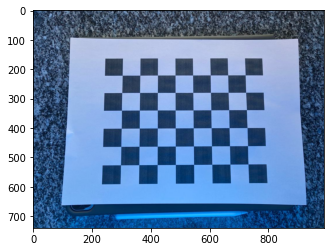

In [15]:
img = cv2.imread('images/Chessboard_real_1.jpeg')
h,  w = img.shape[:2]
newcameramtx, roi = cv2.getOptimalNewCameraMatrix(mtx, dist, (w,h), 1, (w,h))

print(newcameramtx)
# undistort
dst = cv2.undistort(img, mtx, dist, None, newcameramtx)
# crop the image
x, y, w, h = roi
dst = dst[y:y+h, x:x+w]
plt.imshow(dst)


## 4. Re-projection Error
Could not implement OpenCV's Reprojection error. Followed https://stackoverflow.com/questions/23781089/opencv-calibratecamera-2-reprojection-error-and-custom-computed-one-not-agree

In [16]:
tot_error = 0
total_points = 0

for i in range(len(worldcoo)):
    imgpoints2, _ = cv2.projectPoints(worldcoo[i], rvecs[i], tvecs[i], mtx, dist)
    imgpoints2 = imgpoints2.reshape(-1,2)
    tot_error += np.sum(np.abs(imagecoo[i]-imgpoints2)**2)
    total_points += len(worldcoo[i])
    
mean_error=np.sqrt(tot_error/total_points)
print("Mean reprojection error: ", mean_error)

Mean reprojection error:  2.342098575459422


In [17]:
mean_error = 0
for i in range(len(worldcoo)):
    imgpoints2, _ = cv2.projectPoints(worldcoo[i], rvecs[i], tvecs[i], mtx, dist)
    #error = cv2.norm(imagecoo[i], imgpoints2, cv2.NORM_L2)/len(imgpoints2)
    imgpoints2 = imgpoints2.reshape(-1,2)
    # error mean for each point in the  each image
    error = np.sum(np.abs(imagecoo[i]-imgpoints2)**2)/len(imgpoints2)
    # sum of each coordinate error
    mean_error += error
    print(error)
print(mean_error)
print( "total error: {}".format(mean_error/len(worldcoo)) )


0.04491182665030161
0.07488805055618286
0.07616548240184784
0.12696258227030435
0.10608675082524617
0.12667447328567505
0.11839750409126282
0.10206447045008342
0.25236618518829346
1.0285173257191975
total error: 0.11427970285768861


In [18]:
mean_error = 0
for i in range(len(worldcoo)):
    imgpoints2, _ = cv2.projectPoints(worldcoo[i], rvecs[i], tvecs[i], mtx, dist)
    imgpoints2 = imgpoints2.reshape(-1,2)
    error = np.sum(np.abs(imagecoo[i]-imgpoints2)**2)/len(imgpoints2)
    mean_error += error*error
print( "total error: {}".format(mean_error/(len(worldcoo)*len(worldcoo[0]))) )


total error: 0.016107845300896862


In [19]:
#print(imagecoo[len(worldcoo)-1])
#print(imgpoints2)
x = np.sum(np.abs(imagecoo[len(worldcoo)-1] -imgpoints2)**2)/len(imgpoints2)
print(x)

0.25236618518829346
